In [104]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('Data/train.csv') # Loads in the training data
data.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
---
<br>

# **Introduction**
I started constructing this notebook after stumbling upon a video made by Samson Zhang. He explained how learning the foundational concepts of a neural network without the assistance of popular libraries/frameworks such as TensorFlow, PyTorch, and Keras enabled him to gain a more thorough understanding of machine learning. As I tried to understand what was happening in their notebook, I spent hours trying to connect all the dots between dozens of sources and figure out *why* this model worked and *how* we got the calculations. That's when I decided to organize everything into one, comprehensive notebook that is understandable to most people with a surface-level understanding of calculus, linear algebra, and python.

This notebook was inspired by and modeled after one created by Samson Zhang, found [here](https://www.kaggle.com/code/wwsalmon/simple-mnist-nn-from-scratch-numpy-no-tf-keras/notebook). I have added additional features and made some modifications to improve performance.

Additionally, I have implemented object-oriented programming (OOP) to improve modularity. **This guide will assume the use of 3 total layers with the hidden layer using ReLU as its activation function.** Knowing what those mean isn't important right now (we'll cover them later). **It will also use indexing throughout to represent these layers ([0], [1], [2])**. It's important that you remember that altering the number of layers and the activation functions may affect the logic of this guide.

The MNIST dataset is from Kaggle, found [here](https://www.kaggle.com/c/digit-recognizer).
<br>
<br>

---
---

In [105]:
data = np.array(data)
np.random.shuffle(data) # Shuffles the data to prevent overfitting

class PreprocessData:
    """
    This class is used to preprocess the data and split it into training and validation sets.

    Attributes:
        data (np.array): The data to be preprocessed.
        m (int): The number of training examples.
        n (int): The number of features.
        X (np.array): The input features (data directly from the images).
        Y (np.array): The true labels (correct "answers").
    """
    def __init__(self, data):
        self.data = data
        self.m, self.n = self.data.shape # Assigns the dimensions of the data to m and n
        self.X = None
        self.Y = None

    @property
    def input_size(self):
        if self.X is not None:
            return self.X.shape[0]
        else:
            return None

    def normalize(self):
        self.X = self.X / 255.0

class Validate(PreprocessData):
    """
    This subclass is used to preprocess the validation data.
    """
    validate_data = None

    def __init__(self, data, dataset_size=1000):
        super().__init__(data)
        self.size = dataset_size
        self.data = self.data[0:self.size].T
        self.m, self.n = self.data.shape
        self.Y = self.data[0]
        self.X = self.data[1:, :]
        self.normalize()
        Validate.validate_data = self

class Train(PreprocessData):
    """
    This subclass is used to preprocess the training data.
    """
    def __init__(self, data):
        super().__init__(data)
        self.size = Validate.validate_data.size
        self.data = self.data[self.size:self.m].T
        self.Y = self.data[0]
        self.X = self.data[1:, :]
        self.normalize()
        _, self.m = self.X.shape

validate_data = Validate(data, dataset_size=1000)
train_data = Train(data)

In [106]:
class Layer:
    """
    A class used to represent a layer in a neural network.

    Attributes:
        nodes (int): The number of nodes in the layer.
        activation (str): The activation function to use for the layer.
        W (np.array): The weight matrix for the layer.
        b (np.array): The bias vector for the layer.
        Z (np.array): The pre-activation values for the layer.
        A (np.array): The activation values for the layer.
        dW (np.array): The gradient of the cost function with respect to W.
        db (np.array): The gradient of the cost function with respect to b.
        dZ (np.array): The gradient of the cost function with respect to Z.
    """
    def __init__(self, nodes, activation='input'):
        self.nodes = nodes
        self.activation = activation
        self.W = None
        self.b = None
        self.Z = None
        self.A = None
        self.dW = None
        self.db = None
        self.dZ = None

    def __repr__(self):
        """
        Returns the string representation of the layer.
        """
        return f'Layer(nodes={self.nodes}, activation={self.activation})'

    def randomize_parameters(self, prev_nodes):
        """
        Randomly initializes the weight matrix and bias vector for the layer.

        Args:
            prev_nodes (int): The number of nodes in the previous layer.
        """
        self.W = np.random.rand(self.nodes, prev_nodes) - 0.5
        self.b = np.random.rand(self.nodes, 1) - 0.5

    def update_one_hot_Y(self, one_hot_Y):
        """
        Updates the one_hot_Y attributes of the layer.
        """
        self.one_hot_Y = one_hot_Y

    def forward_propagation(self, prev_layer_input):
        """
        Calculates the pre-activation and activation values for the layer.

        Args:
            prev_layer_input (np.array): The input values from the previous layer.
        """
        self.Z = self.W.dot(prev_layer_input) + self.b
        self.A = ActivationFunction.function(self.activation, self.Z)

    def backpropagation(self, prev_layer, next_layer, is_first_layer=False):
        """
        Calculates the gradients of the cost function with respect to W, b, and Z.

        Args:
            prev_layer (Layer): The previous layer.
            next_layer (Layer): The next layer.
            is_first_layer (bool): Whether the layer is the first hidden layer.
        """
        m = self.A.shape[1]

        if next_layer is None: # Indicates the output layer
            self.dZ = self.A - self.one_hot_Y
        else:
            self.dZ = next_layer.W.T.dot(next_layer.dZ) * ActivationFunction.derivative(self.activation, self.Z)

        if is_first_layer:
            self.dW = self.dZ.dot(prev_layer.T) / m
        else:
            self.dW = self.dZ.dot(prev_layer.A.T) / m

        self.db = np.sum(self.dZ, axis=1, keepdims=True) / m

In [107]:
class ActivationFunction:
    """
    A class used to represent and calculate an activation function and its derivative.
    """
    @staticmethod
    def function(name, Z):
        if name == 'input':
            return Z
        elif name == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif name == 'tanh':
            return np.tanh(Z)
        elif name == 'relu':
            return np.maximum(Z, 0)
        elif name == 'softmax':
            return np.exp(Z) / np.sum(np.exp(Z), axis=0)

    @staticmethod
    def derivative(name, Z):
        if name == 'sigmoid':
            s = 1 / (1 + np.exp(-Z))
            return s * (1 - s)
        elif name == 'tanh':
            return 1 - np.tanh(Z)**2
        elif name == 'relu':
            return (Z > 0).astype(int)

In [108]:
class NeuralNetwork:
    """
    A class used to represent the neural network.

    Attributes:
        X (np.array): The input features.
        Y (np.array): The true labels.
        one_hot_Y (np.array): The one-hot encoded true labels.
        layers (dict): The layers of the neural network.
        layer_names (list): The names of the layers.
        layer_objs (list): The layer objects.
        layer_ct (int): The number of layers.
        input_layer (Layer): The input layer.
        hidden_layers (list): The hidden layers.
        output_layer (Layer): The output layer.
        cost_list (list): The cost values for each iteration.
        accuracy_list (list): The accuracy values for each iteration.
        iteration_list (list): The iteration values for each iteration.
        visualizer (Visualizer): The visualizer for the neural network.
    """
    def __init__(self, X, Y, layers):
        self.X = X
        self.Y = Y
        self.one_hot_Y = self.one_hot_encode()
        self.layers = layers
        self.layer_names = []
        self.layer_objs = []
        self.layer_ct = None
        self.input_layer = None
        self.hidden_layers = None
        self.output_layer = None

        self.get_layers()
        self.initialize_parameters()

        self.learning_rate_list = []
        self.cost_list = []
        self.accuracy_list = []
        self.iteration_list = []
        self.visualizer = Visualizer(self)

    def get_layers(self):
        """
        Converts the layer dictionary into a list of layer objects and names. Sets the input, hidden, and output layers and error checks to ensure the layers are valid.
        """
        input_activation_count = 0
        softmax_activation_count = 0

        for name, layer in self.layers.items():
            self.layer_names.append(name)
            self.layer_objs.append(layer)

            if layer.activation == 'input':
                input_activation_count += 1
            elif layer.activation == 'softmax':
                softmax_activation_count += 1

            if layer.activation not in ['input', 'sigmoid', 'tanh', 'relu', 'softmax']:
                raise Exception(f'Invalid activation function for {name}. Must use \'sigmoid\', \'tanh\', \'relu\', or \'softmax\'.')

        self.layer_ct = len(self.layer_objs)
        self.input_layer = self.layer_objs[0]
        self.hidden_layers = self.layer_objs[1:-1]
        self.output_layer = self.layer_objs[-1]

        conditions = {
            self.layer_ct < 3: 'Invalid number of layers. Must have at least 1 input layer, 1 hidden layer, and 1 output layer.',
            input_activation_count > 1: 'More than one layer has the \'input\' activation function.',
            softmax_activation_count > 1: 'More than one layer has the \'softmax\' activation function.',
            self.input_layer.activation != 'input': f'First layer must be an input layer. Can\'t use {self.input_layer.activation}',
            self.output_layer.activation != 'softmax': f'Last layer must use softmax. Can\'t use {self.input_layer.activation}'
        }

        for condition, message in conditions.items():
            if condition:
                raise Exception(message)

    def initialize_parameters(self):
        """
        Initializes the parameters for each layer, except the input layer.
        """
        prev_nodes = 784
        for index, layer in enumerate(self.layer_objs):
            if layer != self.input_layer:
                layer.randomize_parameters(prev_nodes)
                prev_nodes = layer.nodes

    def one_hot_encode(self):
        """
        One-hot encodes the true labels.
        """
        one_hot_Y = np.zeros((self.Y.size, self.Y.max() + 1))
        one_hot_Y[np.arange(self.Y.size), self.Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y

    @staticmethod
    def print_progress(iteration, accuracy, cost, learning_rate):
        """
        Prints the progress of the neural network during training.

        Args:
            iteration (int): The current iteration.
            accuracy (float): The current accuracy.
            cost (float): The current cost.
        """
        print(f'Iteration: {iteration}')
        print(f'Learning rate: {learning_rate:,.3f}')
        print(f'Accuracy: {accuracy:.3f}%')
        print(f'Cost: {cost:,.3f}\n')

    @staticmethod
    def calculate_cost(output_activations, one_hot_Y, m):
        """
        Calculates the cost of the neural network using cross-entropy loss.

        Args:
            output_activations (np.array): The output activations.
            one_hot_Y (np.array): The one-hot encoded true labels.
            m (int): The number of training examples.
        """
        return -np.sum(one_hot_Y * np.log(output_activations)) / m

    def forward_propagate(self, X):
        """
        Performs forward propagation on the neural network.

        Args:
            X (np.array): The input features.
        """
        self.input_layer.A = X
        prev_layer = self.input_layer

        for layer in self.layer_objs[1:]:
            layer.forward_propagation(prev_layer.A)
            prev_layer = layer

    def backwards_propagate(self):
        """
        Performs backwards propagation on the neural network.
        """
        # Reversed list of layer objects, excluding the input layer
        layer_objs_reversed = self.layer_objs[::-1][:-1]
        next_layer = None

        for index, current_layer in enumerate(layer_objs_reversed):
            # Set prev_layer as input layer for the first hidden layer, or next layer in the list otherwise
            prev_layer = self.X if current_layer == layer_objs_reversed[-1] else layer_objs_reversed[index + 1]

            is_first_layer = current_layer == layer_objs_reversed[-1]
            current_layer.backpropagation(prev_layer, next_layer, is_first_layer)
            next_layer = current_layer

    def update_params(self, alpha):
        """
        Updates the parameters of the neural network as training progresses.

        Args:
            alpha (float): The learning rate.
        """
        for layer in self.layer_objs:
            if layer != self.input_layer:
                layer.W -= alpha * layer.dW
                layer.b -= alpha * layer.db

    def optimizer(self, iterations, print_interval, graph_interval, alpha, decay):
        """
        Optimizes the neural network using gradient descent, which aims to minimize the loss function by adjusting parameters.

        Args:
            iterations (int): The number of iterations to train for.
            print_interval (int): The interval at which to print the progress of the neural network.
            graph_interval (int): The interval at which to store the data that will be graphed.
            alpha (float): The learning rate.
            decay (float): The decay rate.
        """
        m = self.Y.size
        for layer in self.layer_objs:
            layer.update_one_hot_Y(self.one_hot_Y)

        for i in range(iterations):
            self.forward_propagate(self.X)
            self.backwards_propagate()
            self.update_params(alpha)

            decay_rate = iterations / 10
            if i % decay_rate == 0 and i != 0:
                alpha = self.learning_rate_decay(alpha, decay)

            if (i % graph_interval == 0) or (i == iterations - 1):
                output_values = self.output_layer.A
                cost = self.calculate_cost(output_values, self.one_hot_Y, m)
                predictions = self.get_predictions(output_values)
                accuracy_percent = self.get_accuracy(predictions, self.Y) * 100

                self.learning_rate_list.append(alpha)
                self.cost_list.append(cost)
                self.accuracy_list.append(accuracy_percent)
                self.iteration_list.append(i)

                if (i % print_interval == 0) or (i == iterations - 1):
                    self.print_progress(i, accuracy_percent, cost, alpha)


    @staticmethod
    def learning_rate_decay(learning_rate, decay_rate):
        """
        Applies learning rate decay to the learning rate. Uses step decay.

        Args:
            learning_rate (float): The learning rate.
            decay_rate (float): The decay rate.
        """
        return learning_rate * (1 - decay_rate)

    @staticmethod
    def get_accuracy(predictions, Y):
        """
        Calculates the accuracy of the predicted labels by comparing them to the true labels

        Args:
            predictions (np.array): The predictions of the neural network.
            Y (np.array): The true labels.

        Returns:
            The accuracy of the neural network.
        """
        return np.sum(predictions == Y) / Y.size

    @staticmethod
    def get_predictions(output_values):
        """
        Retrieves the predicted labels by finding the index of the maximum value (the highest predicted probability) in each column of A2.

        Args:
            output_values (np.array): The output values of the neural network.

        Returns:
            The predictions of the neural network.
        """
        return np.argmax(output_values, axis=0)

    def make_predictions(self, X):
        """
        Makes predictions using the neural network.

        Args:
            X (np.array): The input features.

        Returns:
            predictions (np.array): The predictions of the neural network.
            output_values (np.array): The output values of the neural network.
        """
        self.forward_propagate(X)
        output_values = self.output_layer.A
        predictions = self.get_predictions(output_values)
        return predictions, output_values

    def test_prediction(self, index, X, Y):
        """
        Tests a single prediction made by the neural network.

        Args:
            index (int): The index of the image to test.
            X (np.array): The input features.
            Y (np.array): The true labels.

        Returns:
            current_image (np.array): The current image.
            output_values (np.array): The output values of the neural network.
            label (int): The true value of the image.
            is_correct (bool): Whether the prediction was correct.
        """
        current_image = X[:, index, None]
        prediction, output_values = self.make_predictions(X[:, index, None])
        label = Y[index]
        is_correct = prediction == label

        return current_image, output_values, label, is_correct

---
---
<br>

# **Results**
This is the exciting part! We can finally see our results!

First, we have to actually train our model (we'll keep it separated from the other code because it takes a while to run, just in case you wanted to tweak any of the subsequent code). Remember, these results are from the training session, not the testing session. Afterward, we'll benchmark our neural network by running it with the validation data we grabbed from our training data and set aside as our "testing" data, and see how the accuracy matches up. Ideally, we want them to be similar, but sometimes it varies.

Then, we'll display some correct and incorrect predictions from the training data, and some graphs to show the progress over time. I enjoy looking at the incorrect predictions because I try to find what could've caused our model to make a mistake.
<br>
<br>

---
---

In [109]:
class Visualizer:
    """
    A class to help visualize the results of our neural network.

    Attributes:
        nn (NeuralNetwork): The neural network we want to visualize.
    """
    def __init__(self, neural_network):
        self.nn = neural_network

    def display_predictions(self, n, display_correct=True):
        """
        Displays n predictions from the neural network.

        Args:
            n (int): The number of predictions to display.
            display_correct (bool): Whether to display correct or incorrect predictions.
        """
        predictions = []
        count = 0
        X, Y = self.nn.X, self.nn.Y
        while count < n:
            random_index = np.random.randint(0, X.shape[1])
            current_image, output_values, label, is_correct = self.nn.test_prediction(random_index, X, Y)

            if is_correct == display_correct:
                predictions.append((output_values, label, current_image))
                count += 1

        num_rows = n // 5 if n % 5 == 0 else n // 5 + 1
        fig, axes = plt.subplots(nrows=num_rows, ncols=5, figsize=(15, num_rows * 3))

        for i, (prediction, label, img) in enumerate(predictions):
            row = i // 5
            col = i % 5
            ax = axes[col] if num_rows == 1 else axes[row, col]
            ax.imshow(img.reshape((28, 28)) * 255, cmap='gray')
            ax.set_title(f"Prediction: {np.argmax(prediction)}\nTrue Label: {label}")
            ax.axis('off')

        if display_correct:
            print('Correct Predictions:\n')
        else:
            print('Incorrect Predictions:\n')

        plt.tight_layout()
        plt.show()

    def graph_stats(self, **kwargs):
        graph_types = {
            'learning_rate': self.nn.learning_rate_list,
            'accuracy': self.nn.accuracy_list,
            'cost': self.nn.cost_list
        }

        for key in kwargs:
            if key.lower() in graph_types:
                formatted_key = key.replace('_', ' ').title()
                fig, ax = plt.subplots()
                ax.plot(self.nn.iteration_list, graph_types[key.lower()])
                ax.set_xlabel('Iteration')
                ax.set_ylabel(formatted_key) if key.lower() != 'accuracy' else ax.set_ylabel(f'{formatted_key} (%)')
                ax.set_title(f'{formatted_key} Progression')
                plt.show()

In [113]:
layers = {
    'input': Layer(nodes=784),
    'hidden1': Layer(nodes=10, activation='relu'),
    'output': Layer(nodes=10, activation='softmax')
}

network = NeuralNetwork(train_data.X, train_data.Y, layers=layers)
network.optimizer(iterations=500, print_interval=100, graph_interval=50, alpha=0.25, decay=0.1)

Iteration: 0
Learning rate: 0.250
Accuracy: 10.624%
Cost: 3.486

Iteration: 100
Learning rate: 0.203
Accuracy: 78.893%
Cost: 0.652

Iteration: 200
Learning rate: 0.164
Accuracy: 84.429%
Cost: 0.505

Iteration: 300
Learning rate: 0.133
Accuracy: 86.251%
Cost: 0.453

Iteration: 400
Learning rate: 0.108
Accuracy: 87.339%
Cost: 0.426

Iteration: 499
Learning rate: 0.097
Accuracy: 87.849%
Cost: 0.410



In [114]:
# Run the model with the validation data
validation_predictions = network.make_predictions(validate_data.X)[0]
validation_accuracy_percent = network.get_accuracy(validation_predictions, validate_data.Y) * 100
print(f'Validation Data Accuracy: {validation_accuracy_percent:.3f}%\n')

Validation Data Accuracy: 89.100%



Correct Predictions:



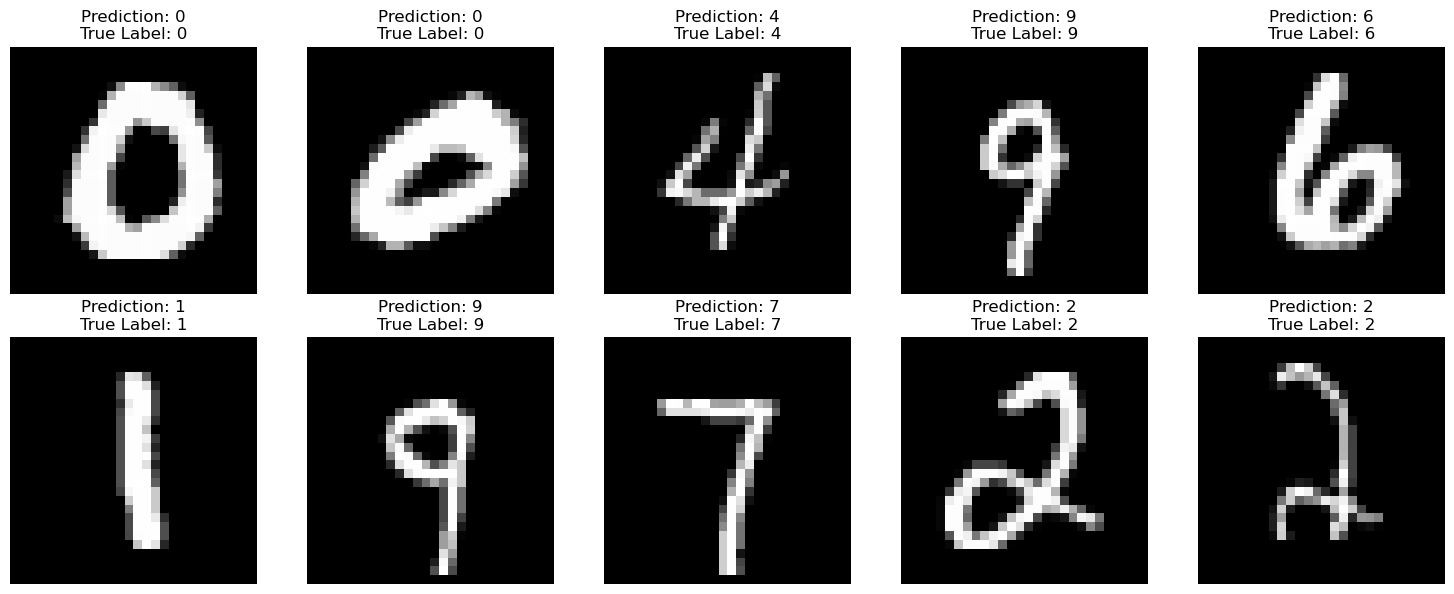

Incorrect Predictions:



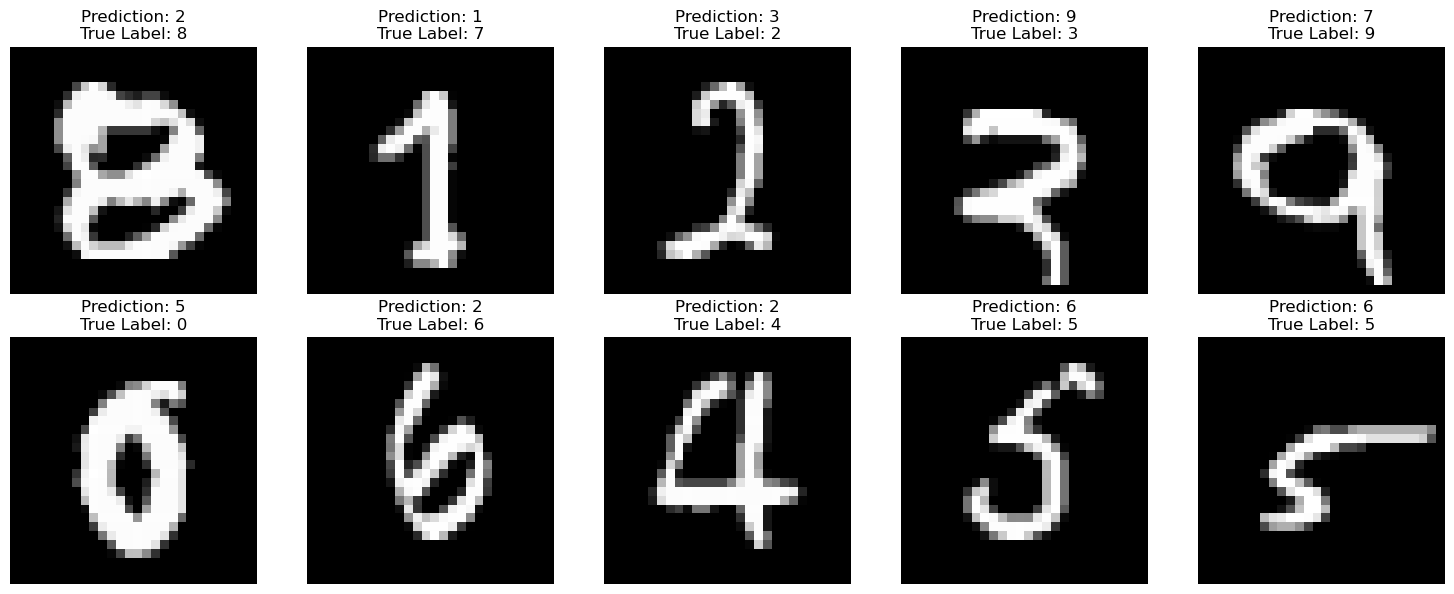

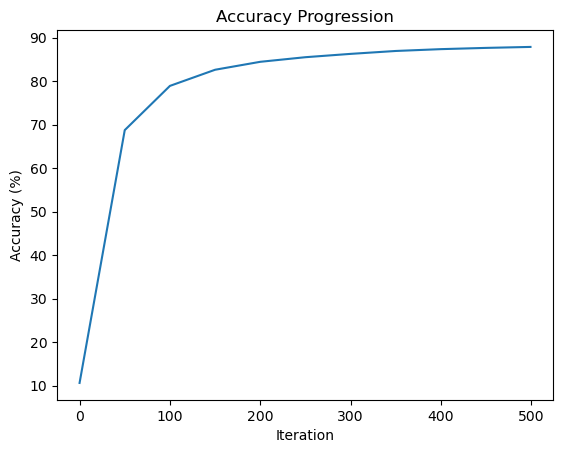

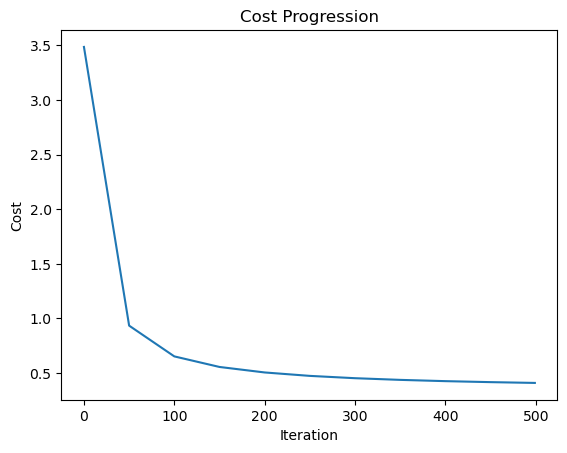

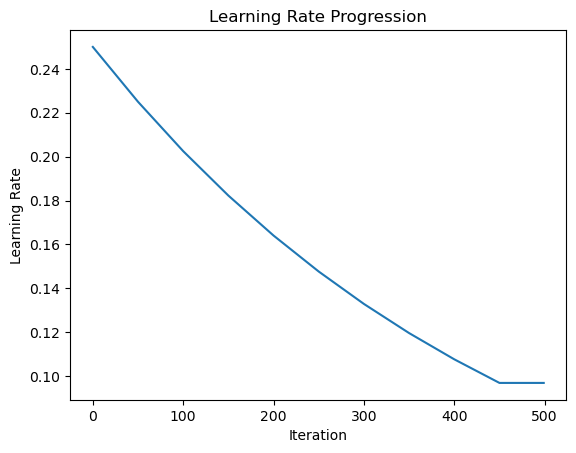

In [115]:
# Visualize the network's performance
visualizer = Visualizer(network)
visualizer.display_predictions(10, display_correct=True)
visualizer.display_predictions(10, display_correct=False)
visualizer.graph_stats(accuracy=True, cost=True, learning_rate=True)